# Time Series Segmentation
In this notebook we are going to showcase a tool we have developed that segments a labeled time series. The time series segmentation tool aims to discover evident behavioral changes.

In particular, we are given a labeled time series for training and at least one time series where we would like to apply our model. The task is to discover points which split the time series into areas with different behavior. In the current setting, we consider two classes/areas with different behavior: aligned and misaligned. We use time series data from wind turbines that are provided by [ENGIE](https://www.engie-deutschland.de/de). With the utilization of the data along with sparse labels that were available, for the yaw alignment or misalignment of a wind turbine. The notebook will focus on this specific dataset, however the methods are not restricted to wind turbines and can be easily used in other problems that can be formulated in a similar manner.

## Loaded libraries used

In [1]:
import re
import os, sys
from tqdm import tqdm
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from modules.preprocessing import *
from modules.inpout import *
from modules.patterns import *
from modules.plots import *

## Loading and preprocessing the dataset
We are going to load the dataset and then perform some preprocessing steps. We are going to filter out some variables (wind speed, rotor speed) of the dataset in order to come down with a clean dataset. The clean dataset will provide regions that our turbine is working optimal. Afterwards we are going to change the granularity of the measurements from two seconds to thirty. Then we are going to filter out some dates.

In [2]:
df=load_df('/usr/local/share/data/more2020/post_treated_data/BEZ/BEBEZE01/BEBEZE01_scada_high_frequency.parquet')
df.index = pd.to_datetime(df.index)
#pick some specific columns
cols = ['wind speed', 'active power', 'rotor speed', 'wind direction', 'nacelle direction', 'pitch angle']
df = df[cols]
print(df.columns)

Index(['wind speed', 'active power', 'rotor speed', 'wind direction',
       'nacelle direction', 'pitch angle'],
      dtype='object')


In [3]:
df.head()

,wind speed,active power,rotor speed,wind direction,nacelle direction,pitch angle
datetime,,,,,,
2018-01-03 00:00:00,11.272275,1936.342041,15.220119,175.347885,180.116089,3.650000
2018-01-03 00:00:02,10.005727,1992.992554,15.229703,186.393020,180.116089,3.886307
2018-01-03 00:00:04,10.507183,2022.112915,15.239287,187.452170,180.116089,4.122613
2018-01-03 00:00:06,10.704224,2027.170776,15.248871,188.673038,180.116089,4.358920
2018-01-03 00:00:08,10.312802,2015.790172,15.258455,189.826151,180.116089,4.595226


In [4]:
# drop values of wind speed under 5m/s
df=filter_col(df, 0, less_than=5, bigger_than=None)
# drop values of rotor speed under 8rpm
df=filter_col(df, 2, less_than=8, bigger_than=None)
# Resample with 30second granularity
df=change_granularity(df,granularity='30s')

Filter Complete
Filter Complete
Resample Complete
Groupping Complete
Chunk Interpolate Done
Interpolate Complete


## Computing the multi-dimensional matrix profile
With the assistance of the [STUMPY](https://stumpy.readthedocs.io/en/latest/index.html) Python library, we are going to compute the multi dimensional matrix profile (will be also denoted as MP) on our dataset. After computing the MP we save it along with the index that accompanies it as a .npz file.

In [5]:
#motif_len = 60  #window size or length of the patterns we are looking for
#column = df.columns # The specific columns we want to build our profile
#path # to be saved path name
mp,mpi= create_mp(df=df,motif_len=60,column=df.columns,path= "./test", dask=False)


We load a precomputed multi dimensional matrix profile for the purpose of our tool with exactly the same configurations. This profile consists of 30 minute patterns.


In [6]:
granularity = '30s'
motif_len=60

cols = ['wind speed', 'active power', 'rotor speed', 'wind direction', 'nacelle direction', 'pitch angle']
sstr = "".join([w[0].upper() for attr in cols for w in re.split('[\s_]', attr + '_.')])
files = ['BEBEZE01', 'BEBEZE02', 'BEBEZE03'] # Three turbines that belong in the same farm
mp = {}
mpi = {}
for file_name in files:
    loaded = np.load(f'matrix-profiles/mp_multivariate_filtered_{file_name}_{granularity}{motif_len}_{sstr.replace(".", "_")[:-1]}.npz', allow_pickle=True)
    mp[file_name] = loaded['mp']
    mpi[file_name] = loaded['mpi']

In the next line we are plotting the timeseries for the power output column and with yellow our multidimensional profile for all the columns

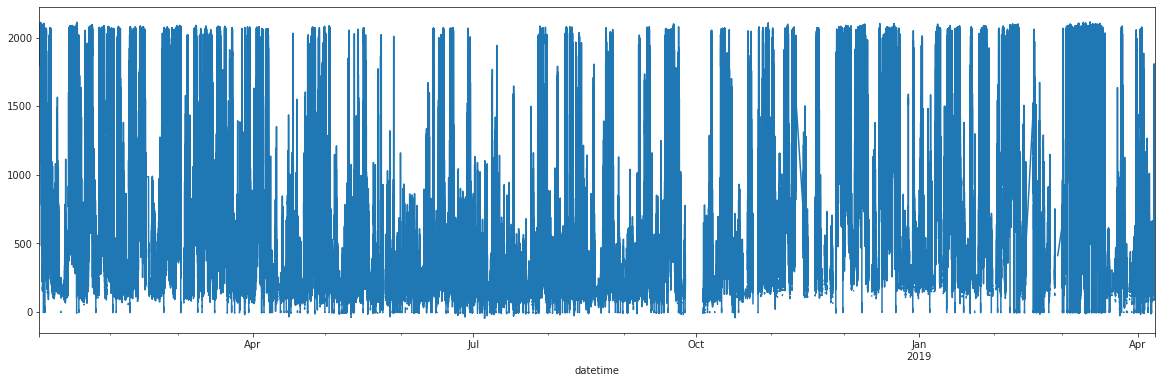

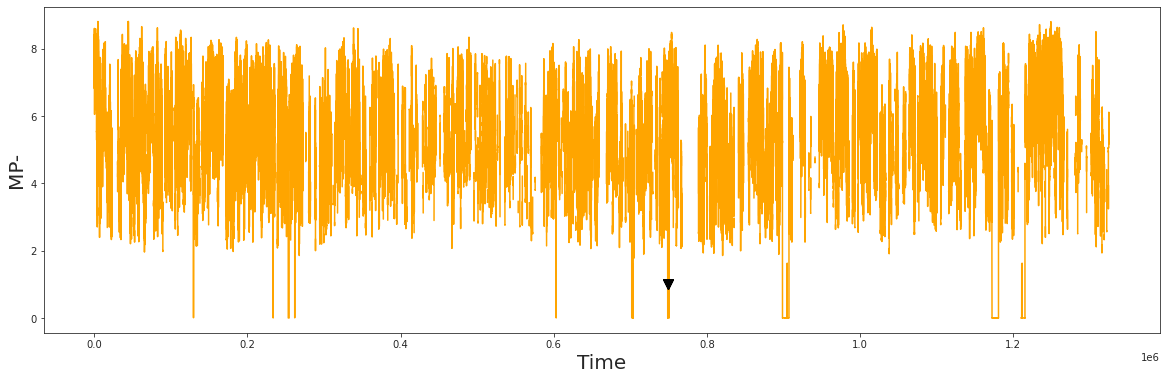

In [7]:
plot_profile(df=df,mp=mp['BEBEZE01'][5],col_name='active power')

# Semantic Segmentation of the Timeseries

When dealing with a multi-dimensional MP one must pick the k most relevant dimensions, as the addition of extra irrelevant dimensions can degrade the perfonrmance of the algorithm significantly. That problem as well as a way to combat it, is described in the paper Matrix Profile VI: Meaningful Multidimensional Motif Discovery, that way is the usage of the "knee" or "elbow" method. According to this method, we plot the minimum value of the MP for each value k of dimensions and find the "turning point". By doing this in our data (as seen in the cell below), we observe that after the value k = 4 the values start to dramatically increase suggesting that the "natural" dimensionality of patterns in our data is for k = 4 number of dimensions. (Since k is 0-idnexed this means 5 dimensions)

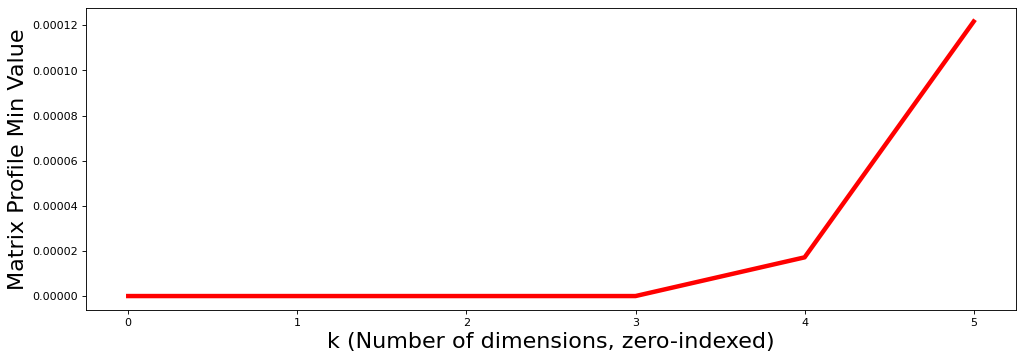

In [8]:
plot_knee(mp['BEBEZE01'])

In this step we will identify the segments we want to divide our timeseries. We search for 5 segments (so to divide to 6 regions, as many as our given labels). Our goal ideally would be to align the segments (blue lines) with the fixed dates (green). This would mean that we found patterns that make sense in a more specific way.More specificaly the calculation of those points comes with respect to a computed Multivariate Matrix Profile.This procedure is illustated through the [Fluss Algorithm](https://stumpy.readthedocs.io/en/latest/_modules/stumpy/floss.html#fluss) that performs semantic segmentation on a time series, into a learning scheme that is able to learn an appropriate configuration of the algorithm for the specific task. This way, the algorithms can learn on the behavior of, e.g. a turbine and be able to segment new turbines into aligned/misaligned areas. We input a L which is a list of integers which is a factor which excludes detecting points to the edges. It replaces the Arc Curve (eg. The plot that we will see in the next lines) with 1 depending of the size of L multiplied with an exclusion Factor (excl_factor). The Arc Curve is essentialy a counter to the existance of neighobors betwen segments. Our goal is that they exist no neighboors between the regions.This procedure is  built through optimal dimensions given from above mentioned elbow method. So in the end we will receive locations(indexes) of the segment points.

In [9]:
# We set different exclusion subsequences lengths in order to create more models and select later
L= np.arange(7000,43000, 2000).astype(int)
output=segment_ts(mpi['BEBEZE01'],k_optimal=5,path=None,L=L,change_points=6,excl_factor=5)

100%|██████████| 18/18 [19:30<00:00, 65.01s/it]


Plotting and scoring. for each L we write down a score at the top of the graph. This score is a distance (dynamic time warping distance) with the fixed dates(labels) and the under inspection segments. We plot all but we keep (save)(up to 5 in the specific example) the minimun distances.

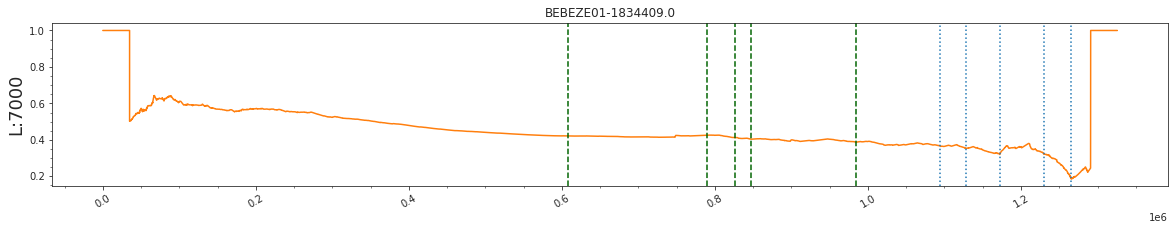

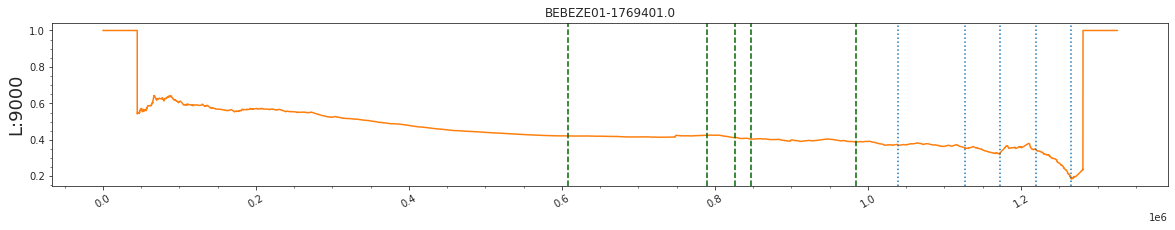

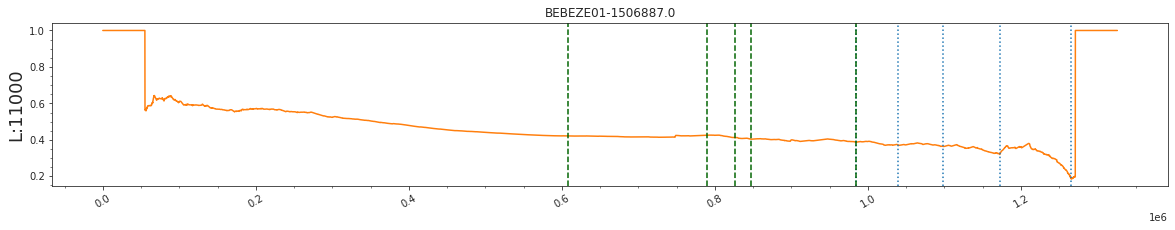

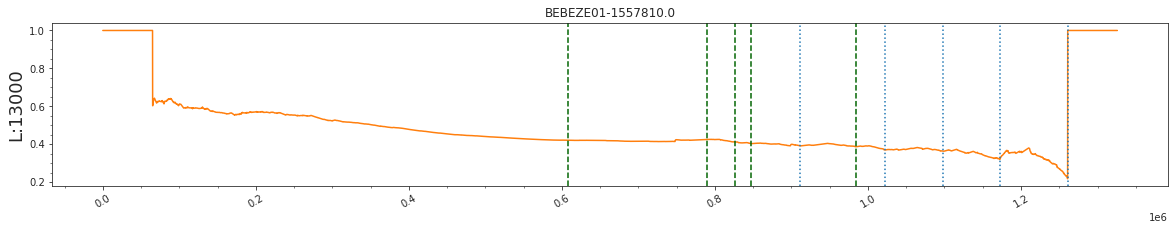

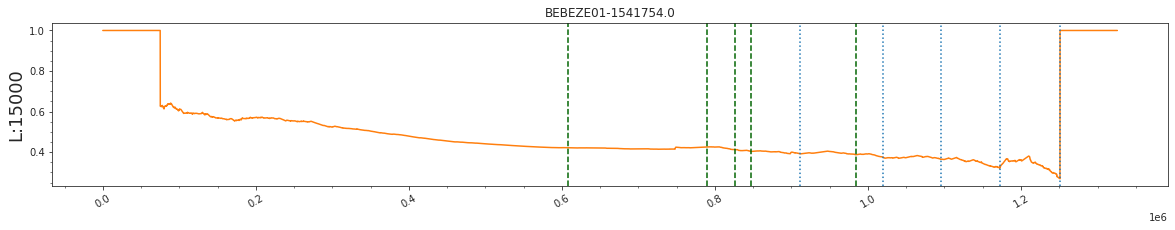

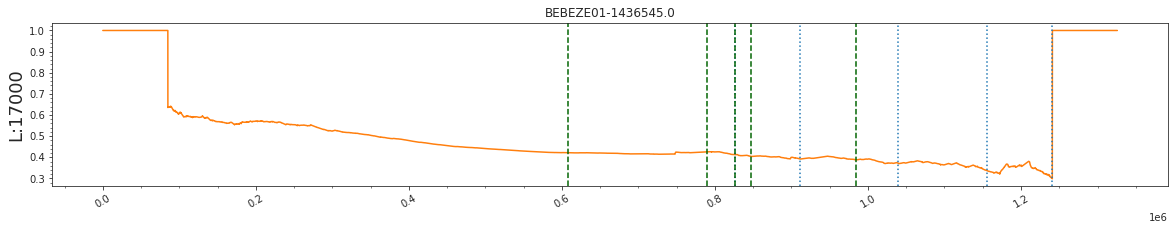

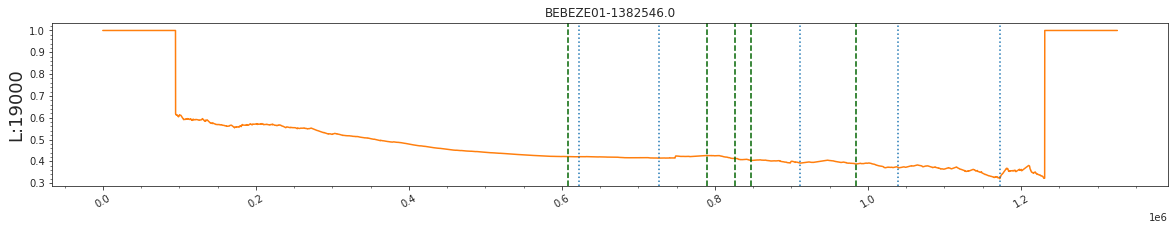

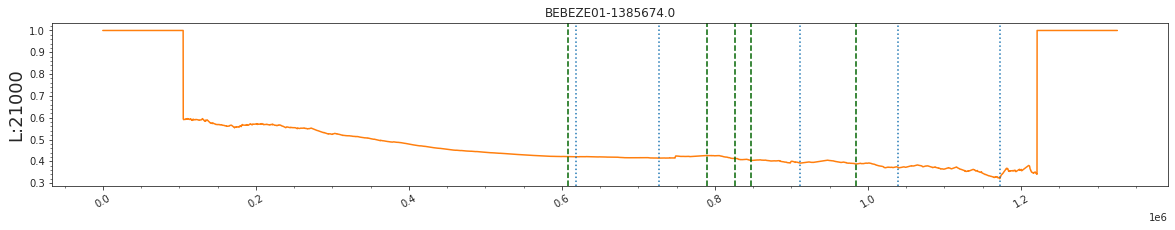

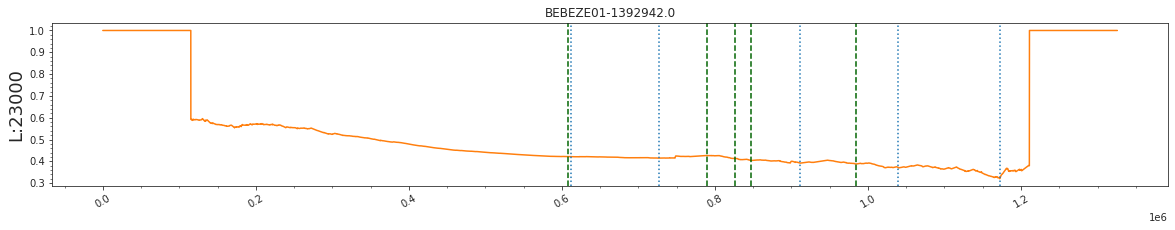

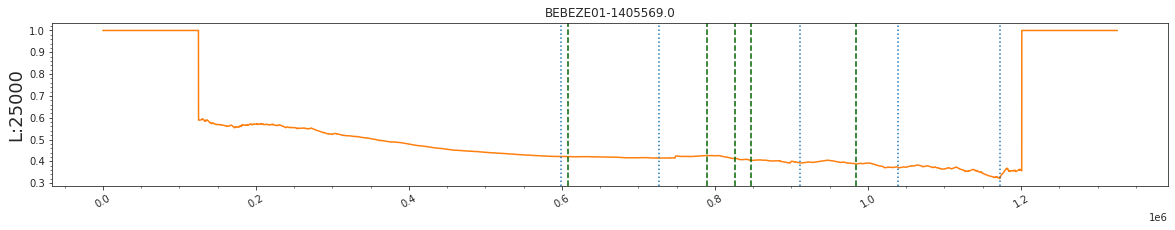

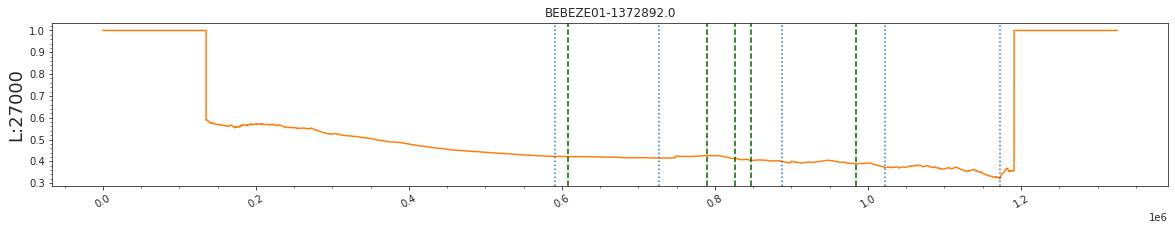

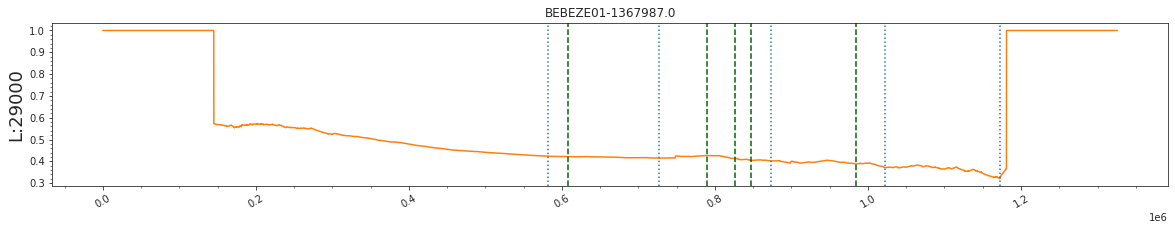

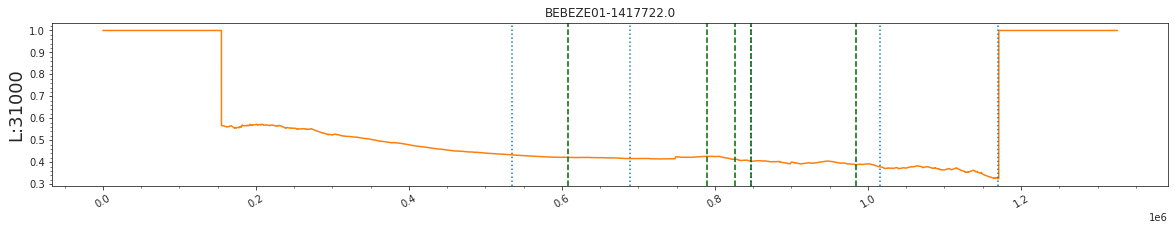

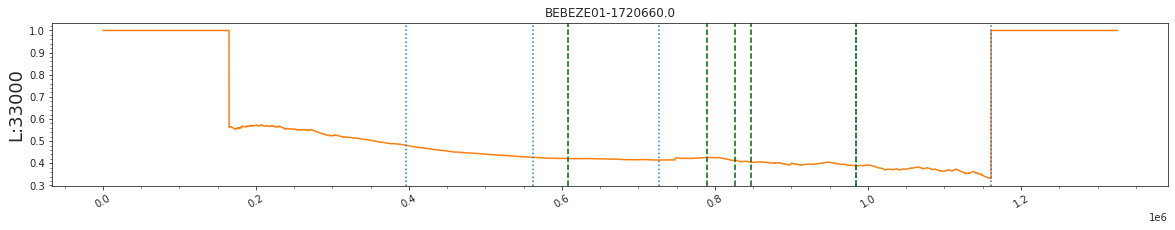

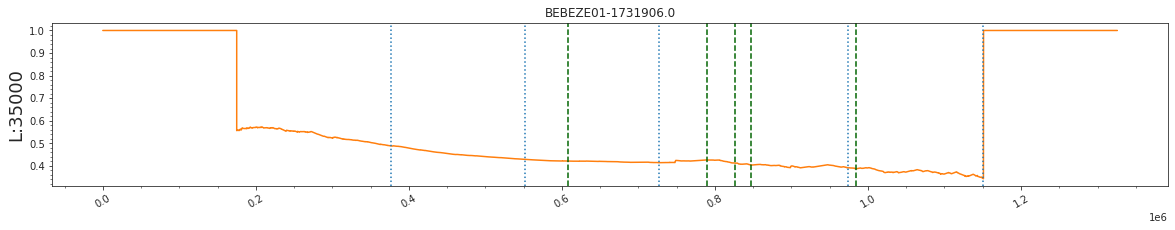

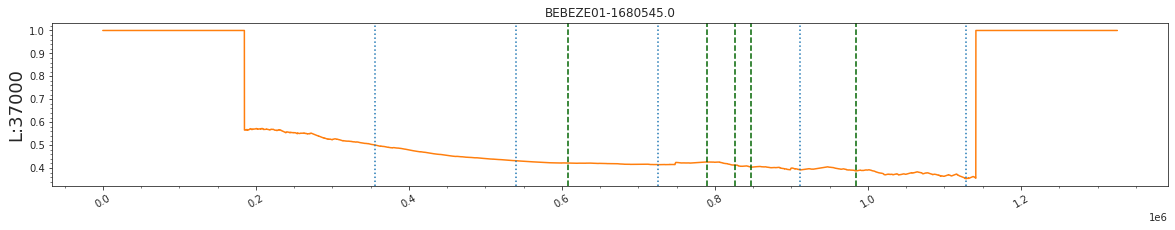

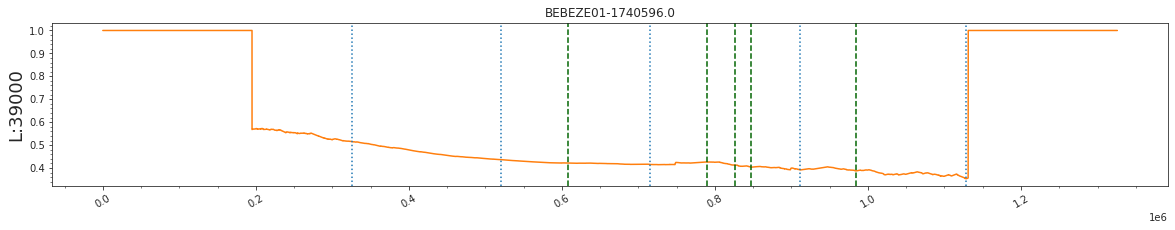

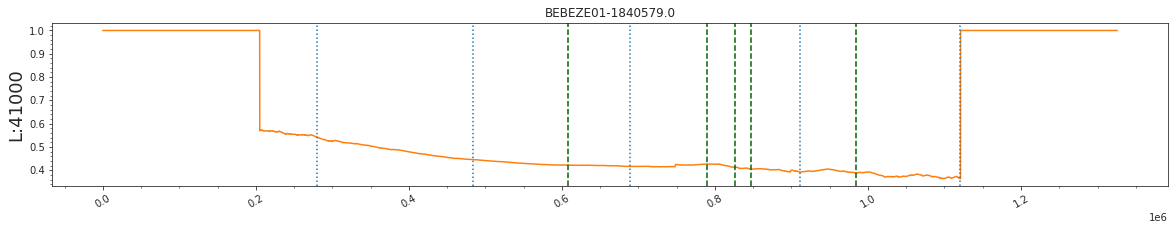

In [10]:
# The provided Labels which segment areas to alligned and misalligend
fixed_dates = [
    '2018-08-02 00:00:00',
    '2018-10-04 00:00:00',
    '2018-10-17 00:00:00',
    '2018-10-24 00:00:00',
    '2018-12-11 00:00:00',
]

best,model =plot_segmentation(df=df,path=None, output=output[0], fixed_dates=fixed_dates, file_name= "BEBEZE01", top_seg=5) 

In [11]:
model

,L,Segment Locations,Distance
0,7000,"[2019-03-18, 2019-02-14, 2019-03-06, 2019-01-2...",0.986944
1,9000,"[2019-03-18, 2019-02-14, 2019-03-02, 2019-01-2...",0.849388
2,11000,"[2019-03-18, 2019-02-14, 2019-01-19, 2018-12-3...",0.293911
3,13000,"[2019-03-16, 2019-02-14, 2019-01-19, 2018-12-2...",0.401664
4,15000,"[2019-03-13, 2019-02-14, 2019-01-18, 2018-12-2...",0.367689
5,17000,"[2019-03-09, 2019-02-08, 2018-12-30, 2018-11-1...",0.145068
6,19000,"[2019-02-14, 2018-12-30, 2018-11-15, 2018-09-1...",0.030807
7,21000,"[2019-02-14, 2018-12-30, 2018-11-15, 2018-09-1...",0.037426
8,23000,"[2019-02-14, 2018-12-30, 2018-11-15, 2018-09-1...",0.052805
9,25000,"[2019-02-14, 2018-12-30, 2018-11-15, 2018-09-1...",0.079523


## Testing of the tool on similar timeseries
In those cells, we are going to redo the previous preprocessing procedure on two other similar timseries (same farm) and test the segmentation algorithm on those series.

In [12]:
cols = ['wind speed', 'active power', 'rotor speed', 'wind direction', 'nacelle direction', 'pitch angle']
#preprocessing at BEBEZE02
df2=load_df('/usr/local/share/data/more2020/post_treated_data/BEZ/BEBEZE02_scada_high_frequency.parquet')
df2.index = pd.to_datetime(df2.index)
df2 = df2[cols]
df2=filter_col(df2, 0, less_than=5, bigger_than=None)
df2=filter_col(df2, 2, less_than=8, bigger_than=None)
df2=change_granularity(df2, granularity='30s')
#mp2,mpi2= create_mp(df=df2,motif_len=60,columns=df2.columns,path="./test",dask=False)

#preprocessing at BEBEZE03
df3=load_df('/usr/local/share/data/more2020/post_treated_data/BEZ/BEBEZE03_scada_high_frequency.parquet')
df3.index = pd.to_datetime(df3.index)
df3 = df3[cols]
df3=filter_col(df3, 0, less_than=5, bigger_than=None)
df3=filter_col(df3, 2, less_than=8, bigger_than=None)
df3=change_granularity(df3, granularity='30s')
#mp3,mpi3= create_mp(df=df3,motif_len=60,columns=df3.columns,path="./test",dask=False)

Filter Complete
Filter Complete
Resample Complete
Groupping Complete
Chunk Interpolate Done
Interpolate Complete
Filter Complete
Filter Complete
Resample Complete
Groupping Complete
Chunk Interpolate Done
Interpolate Complete


We deploy and validate our model of the learned segmentation on the other two similar datasets.

In [13]:
L=[]
for segmentation in best:
    L.append(segmentation['L'])
L.sort()
#Calculation of the points where segments taking place in the other two turbines
output2=segment_ts(mpi['BEBEZE02'],k_optimal=5,path=None,L=L,change_points=6,excl_factor=5)
output3=segment_ts(mpi['BEBEZE03'],k_optimal=5,path=None,L=L,change_points=6,excl_factor=5)

100%|██████████| 5/5 [05:18<00:00, 63.67s/it]


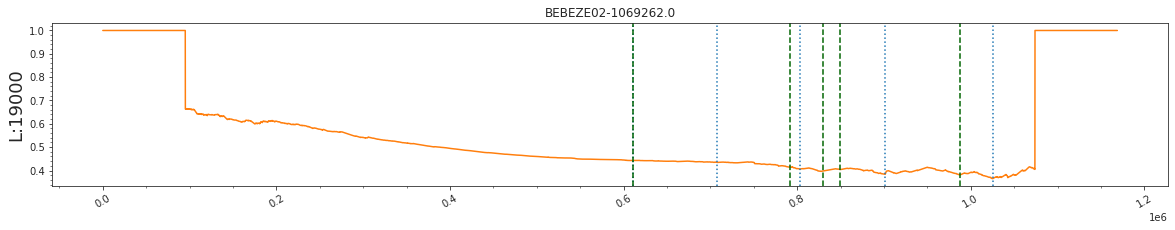

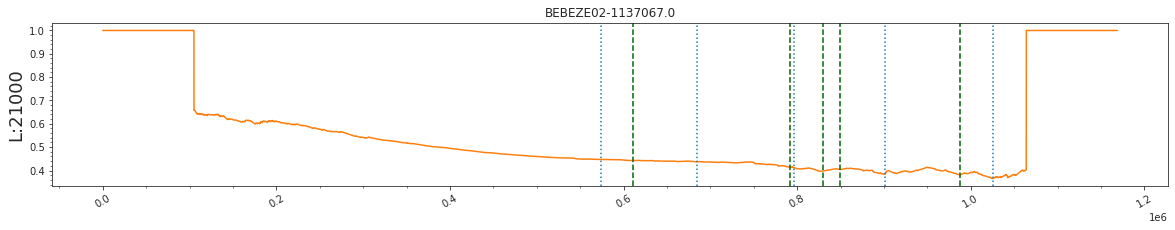

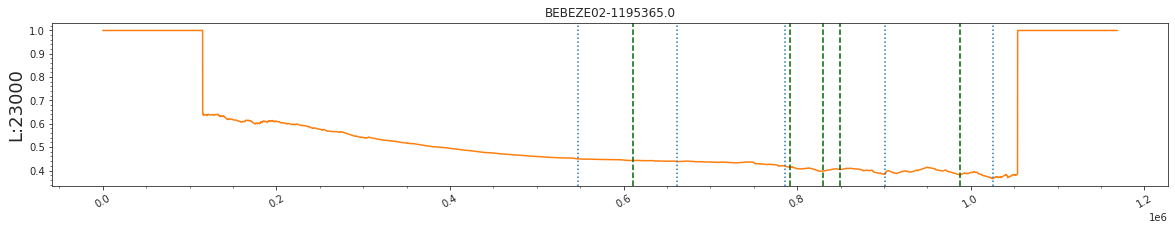

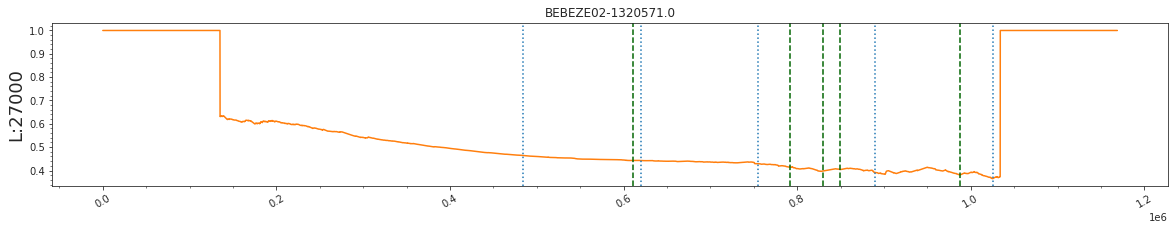

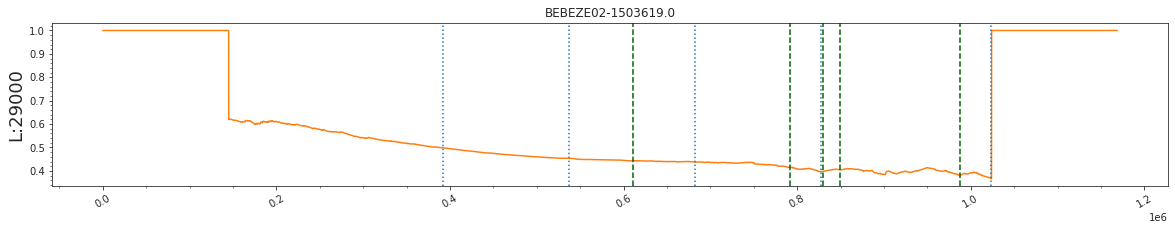

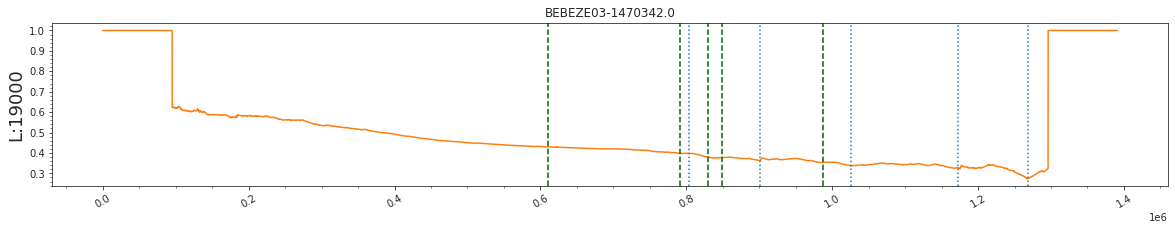

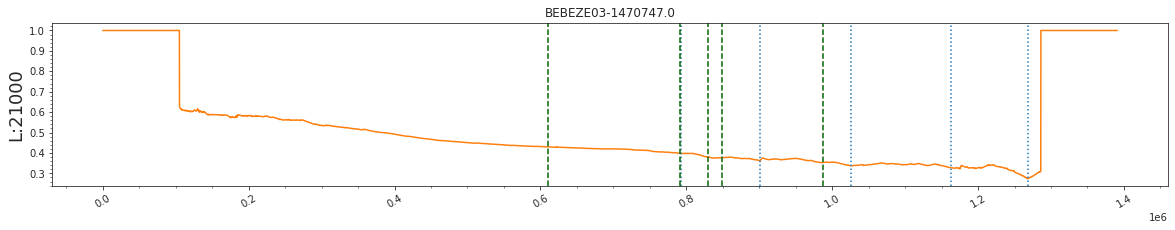

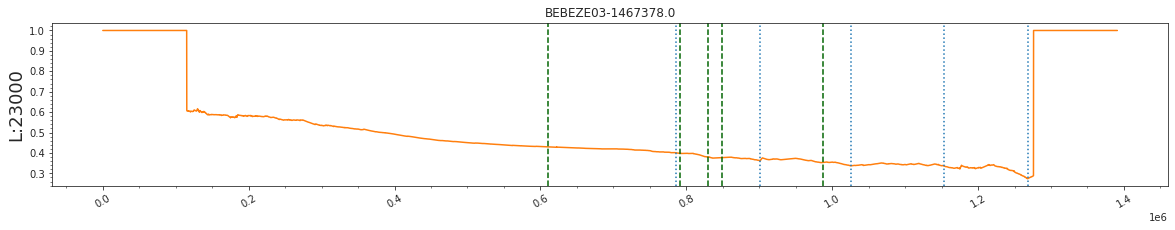

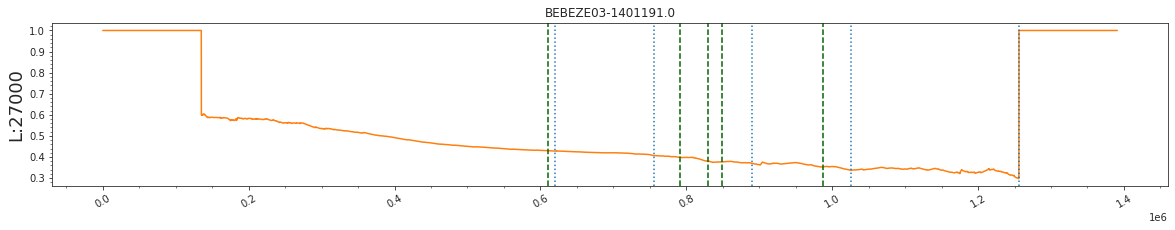

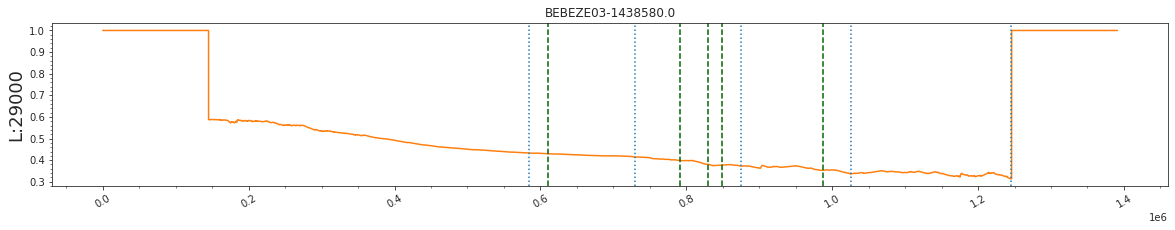

In [14]:
best2,model2=plot_segmentation(df2,path=None, output=output2[0], fixed_dates=fixed_dates,file_name= "BEBEZE02", top_seg=5)
best3,model3=plot_segmentation(df3,path=None, output=output3[0], fixed_dates=fixed_dates, file_name= "BEBEZE03", top_seg=5)